In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [201]:
from pathlib import Path
import time
import numpy  as np
import nibabel as nib
import matplotlib.pyplot as plt
import midasmednet.dataset
from midasmednet.dataset import LandmarkDataset, SegmentationDataset
from torch.utils.data import Dataset, DataLoader
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.transforms.color_transforms import BrightnessTransform, GammaTransform, ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import ZoomTransform

## Segmentation Trainer (Aorta, one class segmentation, ZARR data storage)

In [210]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/training_1_5_mm_LAS_preprocessed.zarr'
subject_keys = ['100000', '100001', '100002', '100003']
patch_size = [150, 150, 150]
# 50% random patches, %50 patches containing at least one point inside the vessel mask
class_probs = [0.5, 0.5]
# samples per epoch: samples_per_subject*number_of_subjects
samples_per_subject = 2 
# data generator, reads data from zarr file (customizable)
data_reader = midasmednet.dataset.read_zarr

test = Compose([BrightnessTransform(mu=0.0,sigma=0.3, data_key='data'), 
               GammaTransform(gamma_range=(0.7, 1.3), data_key='data'),
             ContrastAugmentationTransform(contrast_range=(0.3, 1.7), data_key='data')])

ds = SegmentationDataset(zarr_path, subject_keys, samples_per_subject, patch_size, 
                         class_probabilities=class_probs, data_reader=data_reader,
                         image_group = 'images_norm', label_group='labels', transform=test)

subject_key:     100000
selected_class:  0
position:        [69 12  0]
data shape:      (1, 1, 150, 150, 150)
label shape:     (1, 1, 150, 150, 150)


<IPython.core.display.Javascript object>


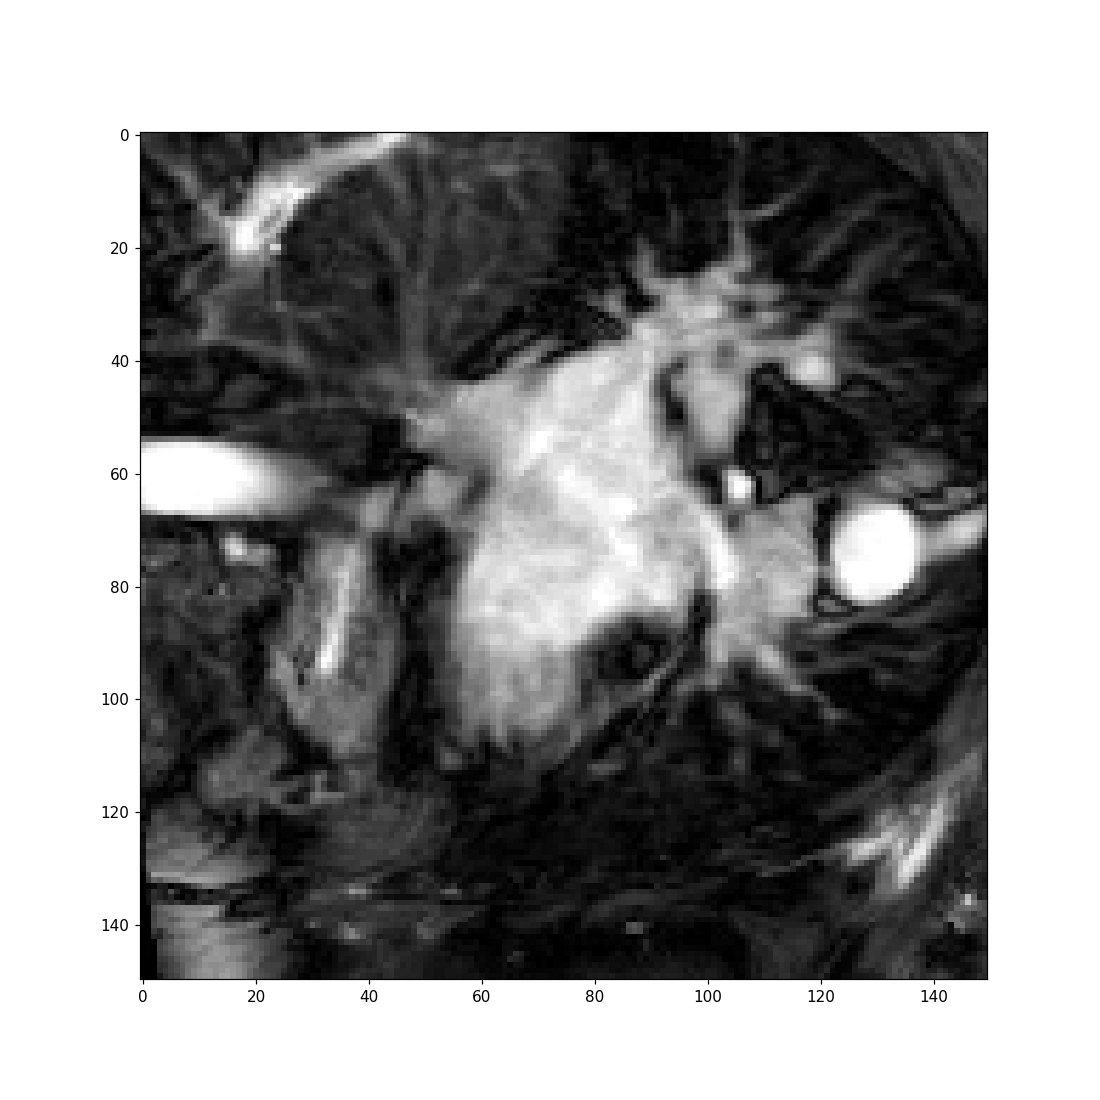

<IPython.core.display.Javascript object>


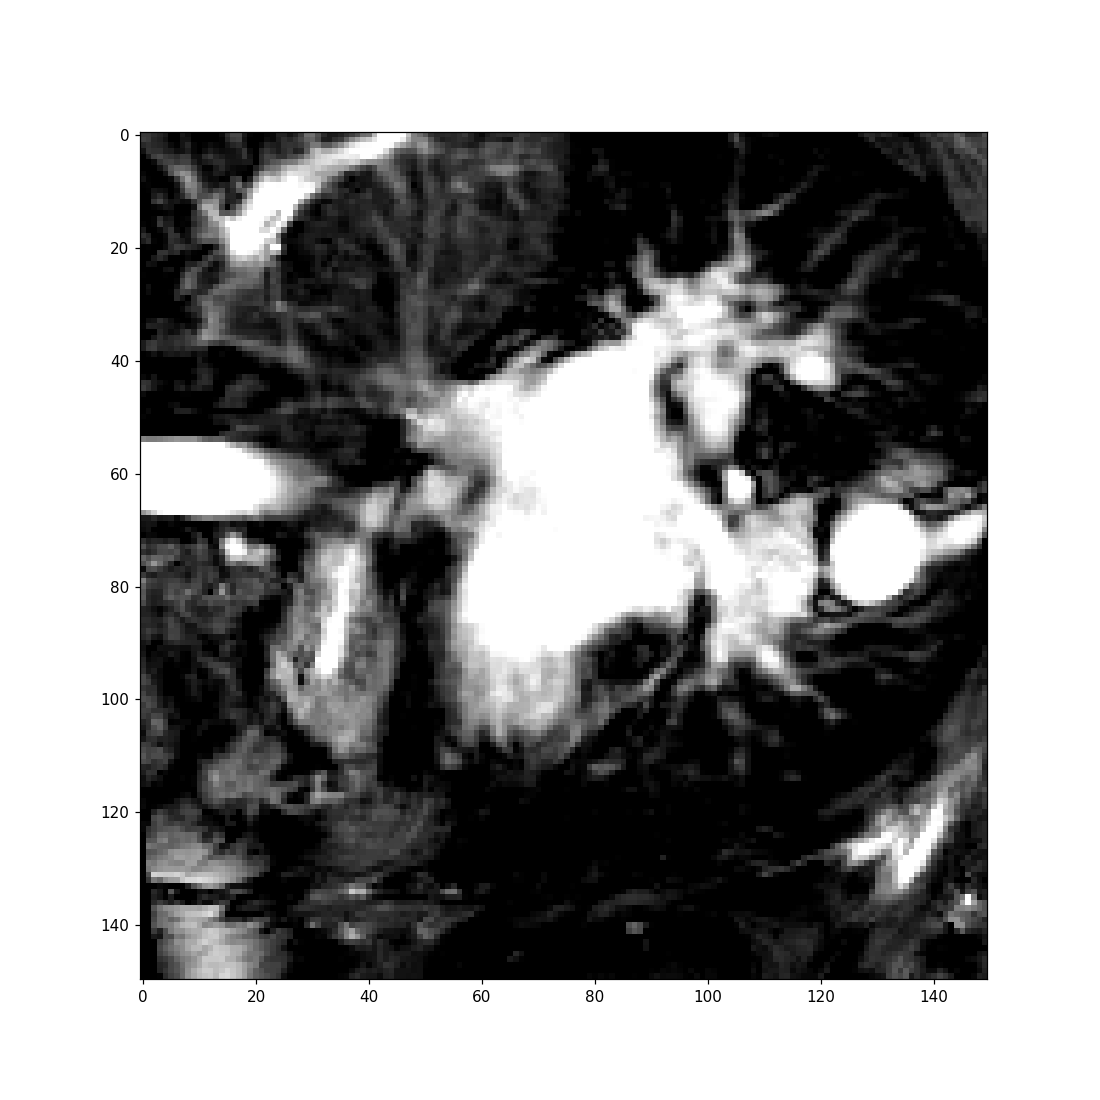

In [214]:
sample = ds[0]
sample['data']=np.expand_dims(sample['data'], axis=0)
sample['label']=np.expand_dims(sample['label'], axis=0)
print('subject_key:    ', sample['subject_key'])
print('selected_class: ', sample['selected_class'])
print('position:       ', sample['patch_position'])
print('data shape:     ', sample['data'].shape)
print('label shape:    ', sample['label'].shape)

plt.figure(figsize=(10,10))
#plt.imshow(np.max(sample['data'][0,...], axis=2), cmap='gray', vmin=0, vmax=3)
plt.imshow(sample['data'][0, 0,:,60,:], cmap='gray')

test = Compose([BrightnessTransform(mu=0.0,sigma=0.3, data_key='data'), 
               GammaTransform(gamma_range=(0.7, 1.3), data_key='data'),
             ContrastAugmentationTransform(contrast_range=(0.3, 1.7), data_key='data'),
                ZoomTransform(zoom_factors=1, order=3, order_seg=1,)
])
sample2 = test(**sample)

plt.figure(figsize=(10,10))
#plt.imshow(np.max(sample['data'][0,...], axis=2), cmap='gray', vmin=0, vmax=3)
plt.imshow(sample2['data'][0, 0,:,60,:], cmap='gray')

<IPython.core.display.Javascript object>


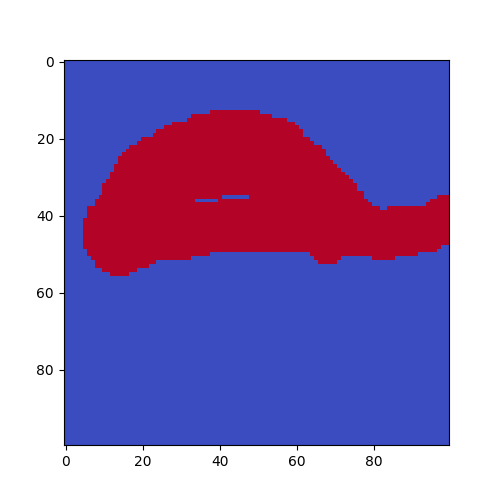

In [425]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['label'][0,...], axis=2), cmap='coolwarm')

## Segmentation Trainer (CT organs, multi class segmentation, Nifti files)

In [450]:
data_path = '/mnt/share/raheppt1/data/metvol/interim/ctorgan/nifti/nifti_lowres'
subject_keys = ['023', '024', '025', '026']
patch_size = [100, 100, 100]
class_probs = [0.5, 0.2, 0.3, 0.4]
# samples per epoch: samples_per_subject*number_of_subjects
samples_per_subject = 2 
# data generator, reads data from nifti files (customizable)
# dir structure: <data_path>/<image_group>/<subj_key>...nii...
data_reader = midasmednet.dataset.read_nifti
ds = SegmentationDataset(data_path, subject_keys, samples_per_subject, patch_size, 
                         class_probabilities=class_probs, data_reader=data_reader,
                         image_group = 'images', label_group='labels')

INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading images/023
DEBUG:midasmednet.dataset:loading images/024
DEBUG:midasmednet.dataset:loading images/025
DEBUG:midasmednet.dataset:loading images/026
DEBUG:midasmednet.dataset:finished: 4.851 s, current memory usage  0.82GB, peak memory usage 4.05GB
INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading labels/023
DEBUG:midasmednet.dataset:loading labels/024
DEBUG:midasmednet.dataset:loading labels/025
DEBUG:midasmednet.dataset:loading labels/026
DEBUG:midasmednet.dataset:finished: 0.594 s, current memory usage  0.90GB, peak memory usage 4.05GB
INFO:midasmednet.dataset:pre-computing sampling maps ...
DEBUG:midasmednet.dataset:finished  0.121 s


In [454]:
sample = ds[0]
print('subject_key:    ', sample['subject_key'])
print('selected_class: ', sample['selected_class'])
print('position:       ', sample['patch_position'])
print('data shape:     ', sample['data'].shape)
print('label shape:    ', sample['label'].shape)

subject_key:     023
selected_class:  3
position:        [115  27 149]
data shape:      (1, 100, 100, 100)
label shape:     (1, 100, 100, 100)


<IPython.core.display.Javascript object>


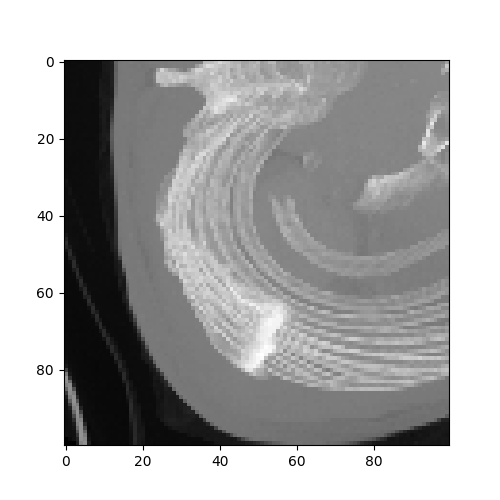

In [455]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['data'][0,...], axis=2), cmap='gray')

<IPython.core.display.Javascript object>


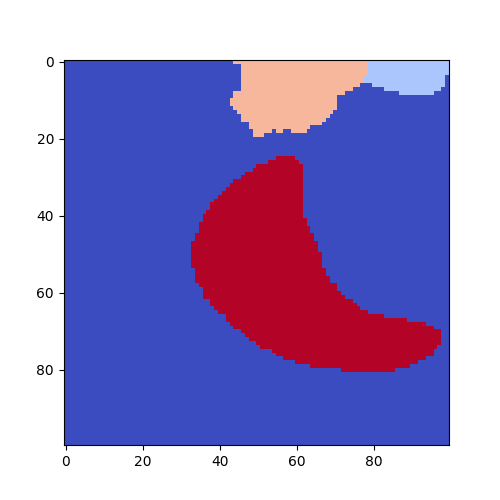

In [456]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['label'][0,...], axis=2), cmap='coolwarm')

## Landmark Trainer (aorta, hdf5 dataset)

In [568]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/hdf5/data.h5'
subject_keys = ['100000', '100001', '100002', '100003']
patch_size = [100, 100, 100]
class_probs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# samples per epoch: samples_per_subject*number_of_subjects
samples_per_subject = 20 
# data generator, reads data from hdf file (customizable)
data_reader = midasmednet.dataset.read_h5

ds = LandmarkDataset(zarr_path, subject_keys, samples_per_subject, patch_size, 
                         class_probabilities=class_probs, data_reader=data_reader,
                         image_group = 'images_norm', heatmap_group='heatmaps')

INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading images_norm/100000
DEBUG:midasmednet.dataset:loading images_norm/100001
DEBUG:midasmednet.dataset:loading images_norm/100002
DEBUG:midasmednet.dataset:loading images_norm/100003
DEBUG:midasmednet.dataset:finished: 0.307 s, current memory usage  4.28GB, peak memory usage 6.54GB
INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading heatmaps/100000
DEBUG:midasmednet.dataset:loading heatmaps/100001
DEBUG:midasmednet.dataset:loading heatmaps/100002
DEBUG:midasmednet.dataset:loading heatmaps/100003
DEBUG:midasmednet.dataset:finished: 0.713 s, current memory usage  4.48GB, peak memory usage 6.54GB
DEBUG:midasmednet.dataset:generating class labels from heatmaps ...
DEBUG:midasmednet.dataset:finished  4.061 s
DEBUG:midasmednet.dataset:pre-computing sampling maps ...
DEBUG:midasmednet.dataset:finished  0.322 s


In [569]:
sample = ds[0]
print('subject_key:    ', sample['subject_key'])
print('selected_class: ', sample['selected_class'])
print('position:       ', sample['patch_position'])
print('data shape:     ', sample['data'].shape)
print('label shape:    ', sample['label'].shape)

subject_key:     100000
selected_class:  5
position:        [75 83 47]
data shape:      (1, 100, 100, 100)
label shape:     (7, 100, 100, 100)


<IPython.core.display.Javascript object>


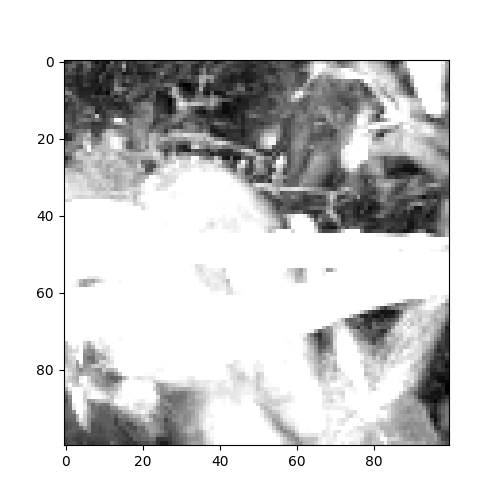

In [570]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['data'][0,...], axis=2), cmap='gray')

<IPython.core.display.Javascript object>


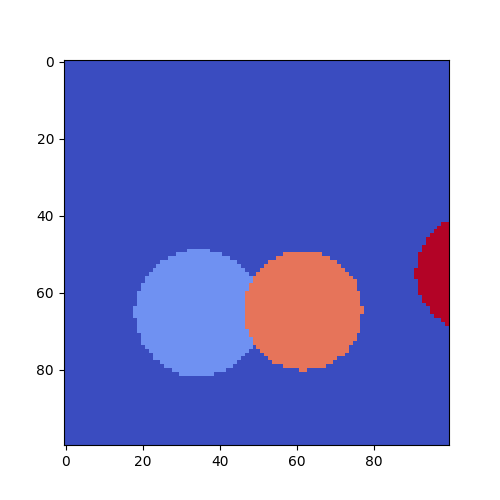

In [571]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['label'][-1,...], axis=2), cmap='coolwarm')

<IPython.core.display.Javascript object>


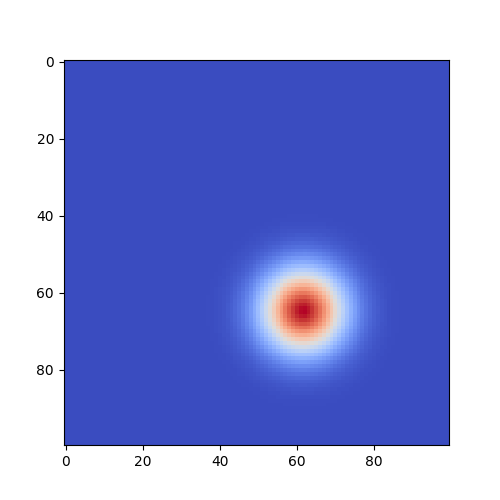

In [572]:
plt.figure(figsize=(5,5))
plt.imshow(np.max(sample['label'][sample['selected_class']-1,...], axis=2), cmap='coolwarm')

### Timing benchmark

In [573]:
# timing benchmark
loader = DataLoader(ds, batch_size=4, shuffle=False, num_workers=4)
t = time.perf_counter()
for sample in loader:
    a = sample
    print(f'elapsed time {time.perf_counter()-t}s')

elapsed time 2.570937456097454s
elapsed time 2.592298157978803s
elapsed time 2.6047241240739822s
elapsed time 2.6379054521676153s
elapsed time 2.953602109104395s
elapsed time 2.963748559122905s
elapsed time 3.1441445611417294s
elapsed time 3.1806140991393477s
elapsed time 3.3276376540306956s
elapsed time 3.333638569107279s
elapsed time 3.474139163037762s
elapsed time 3.518150980118662s
elapsed time 3.7011922150850296s
elapsed time 3.7703206511214375s
elapsed time 3.776923367055133s
elapsed time 3.855303662130609s
elapsed time 4.018303366145119s
elapsed time 4.023105836007744s
elapsed time 4.031563799129799s
elapsed time 4.039012813009322s


## Example: Slice sampling (aorta, hdf5 dataset)

In [557]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/hdf5/data.h5'
subject_keys = ['100000', '100001', '100002', '100003']
patch_size = [100, 100, 1]
# 50% random patches, %50 patches containing at least one point inside the vessel mask
class_probs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# samples per epoch: samples_per_subject*number_of_subjects
samples_per_subject = 100 
# data generator, reads data from hdf file (customizable)
data_reader = midasmednet.dataset.read_h5

ds = LandmarkDataset(zarr_path, subject_keys, samples_per_subject, patch_size, 
                         class_probabilities=class_probs, data_reader=data_reader,
                         image_group = 'images_norm', heatmap_group='heatmaps')

INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading images_norm/100000
DEBUG:midasmednet.dataset:loading images_norm/100001
DEBUG:midasmednet.dataset:loading images_norm/100002
DEBUG:midasmednet.dataset:loading images_norm/100003
DEBUG:midasmednet.dataset:finished: 0.981 s, current memory usage  2.41GB, peak memory usage 4.66GB
INFO:midasmednet.dataset:loading data ...
DEBUG:midasmednet.dataset:loading heatmaps/100000
DEBUG:midasmednet.dataset:loading heatmaps/100001
DEBUG:midasmednet.dataset:loading heatmaps/100002
DEBUG:midasmednet.dataset:loading heatmaps/100003
DEBUG:midasmednet.dataset:finished: 1.016 s, current memory usage  2.60GB, peak memory usage 4.66GB
DEBUG:midasmednet.dataset:generating class labels from heatmaps ...
DEBUG:midasmednet.dataset:finished  5.927 s
DEBUG:midasmednet.dataset:pre-computing sampling maps ...
DEBUG:midasmednet.dataset:finished  0.384 s


subject_key:     100000
selected_class:  4
position:        [86 32 90]
data shape:      (1, 100, 100, 1)
label shape:     (7, 100, 100, 1)


<IPython.core.display.Javascript object>


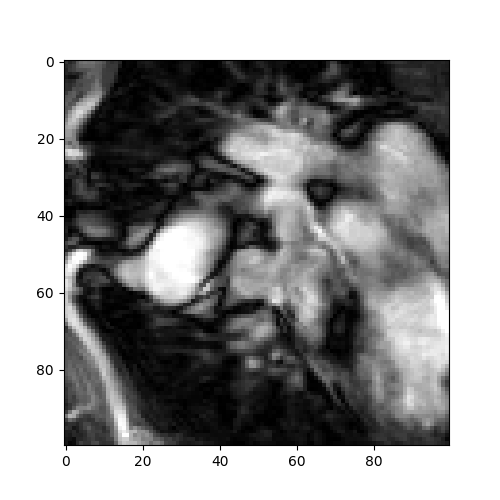

<IPython.core.display.Javascript object>


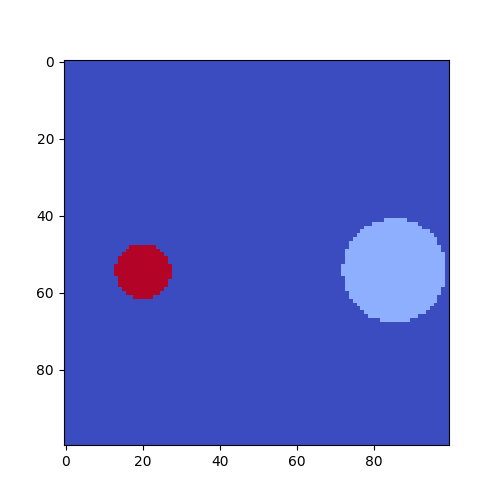

In [558]:
sample = ds[0]
print('subject_key:    ', sample['subject_key'])
print('selected_class: ', sample['selected_class'])
print('position:       ', sample['patch_position'])
print('data shape:     ', sample['data'].shape)
print('label shape:    ', sample['label'].shape)

plt.figure(figsize=(5,5))
plt.imshow(sample['data'][0,:,:,0], cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(sample['label'][-1,:,:,0], cmap='coolwarm')
plt.show()

### Timing benchmark

In [561]:
loader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=4)
t = time.perf_counter()
for sample in loader:
    a = sample
    print(f'elapsed time {time.perf_counter()-t}s')

elapsed time 1.9895397799555212s
elapsed time 1.9908840178977698s
elapsed time 1.9916976150125265s
elapsed time 1.994425630895421s
elapsed time 2.00260626594536s
elapsed time 2.0105393410194665s
elapsed time 2.011334478855133s
elapsed time 2.012061232002452s
elapsed time 2.071078135864809s
elapsed time 2.0747343918774277s
elapsed time 2.0754241289105266s
elapsed time 2.0761037790216506s
elapsed time 2.0998897918034345s
